**Ghouls, Goblins, and Ghosts... Boo:** 
Random Forest Classifier has been used in this project to identify between Ghouls, Goblins and Ghosts based on the given feature. 

In [1]:
# Author : Jo, Gwan Woo, jgw1413@naver.com
# Supervisor : Na, In Seop, ypencil@hanmail.net
# Starting Project : 2019.1.4


#                  GNU LESSER GENERAL PUBLIC LICENSE 
#                        Version 3, 29 June 2007 
# 
 
#  Copyright (C) 2007 Free Software Foundation, Inc. <https://fsf.org/> 
#  Everyone is permitted to copy and distribute verbatim copies 
#  of this license document, but changing it is not allowed. 


# 필수 라이브러리 가져오기
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

import matplotlib.cm as cm
from sklearn import manifold
plt.style.use('seaborn')

In [2]:
# 훈련 및 테스트 파일 읽기
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

submission = pd.read_csv("../input/sample_submission.csv")
submission["type"] = "Unknown"

### Checking if there are any Null values or not. If there are any we need to handle them.

In [3]:
# Null값이 존재하는지 확인(누락된 값 확인)
print("Train Data Null Values Count \n",train_df.isna().sum())
print("Test Data Null Values Count \n",test_df.isna().sum())

Train Data Null Values Count 
 id               0
bone_length      0
rotting_flesh    0
hair_length      0
has_soul         0
color            0
type             0
dtype: int64
Test Data Null Values Count 
 id               0
bone_length      0
rotting_flesh    0
hair_length      0
has_soul         0
color            0
dtype: int64


Since there are no missing values we can continue our work further. If are any missing values I have explained in detail what steps we should take in my [blog](http://https://thedatafreak.wordpress.com/2018/08/16/foreplay-before-doing-data-part-i-handling-missing-data/).

### Taking a look at the distribution
If the features have normal distrubtion we can move forward, else we have to use some transformation for making them normal. 

## Train Data Distribution

C:\Users\user\Anaconda5\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


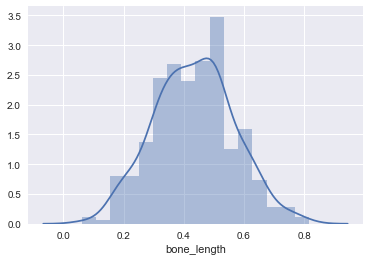

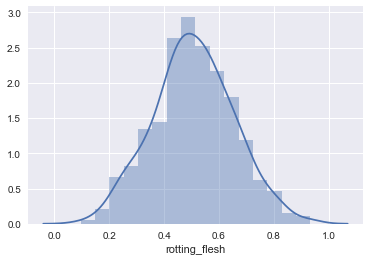

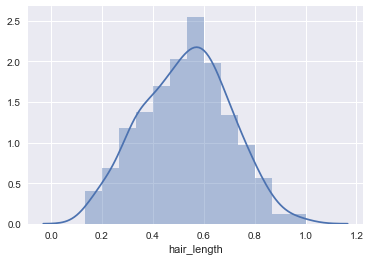

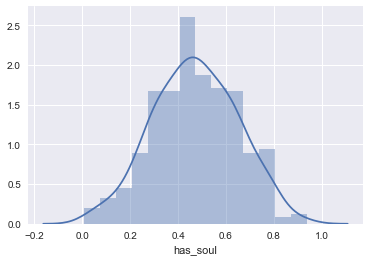

In [4]:
# 훈련 데이터 분포
for col in train_df.drop(columns=['id','color','type'],axis=1).columns:
    sns.distplot(train_df[col])
    plt.show()

## Test Data Distrubtion

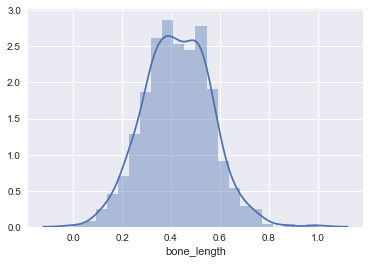

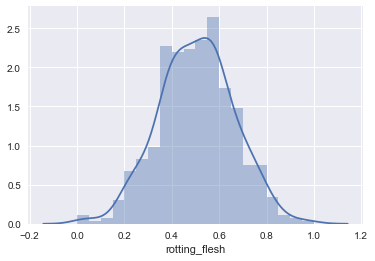

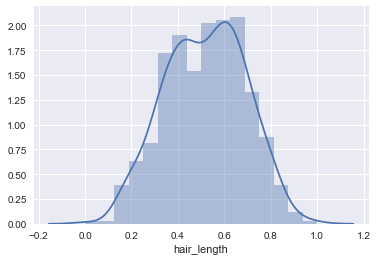

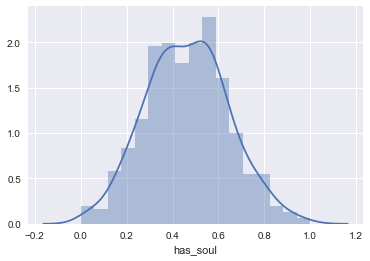

In [5]:
# 테스트 데이터 분포
for col in test_df.drop(columns=['id','color'],axis=1).columns:
    sns.distplot(test_df[col])
    plt.show()

In [6]:
# 훈련 데이터 상위 부분
train_df.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [7]:
# 테스트 데이터 상위 부분
test_df.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color
0,3,0.471774,0.387937,0.706087,0.698537,black
1,6,0.427332,0.645024,0.565558,0.451462,white
2,9,0.549602,0.491931,0.660387,0.449809,black
3,10,0.638095,0.682867,0.471409,0.356924,white
4,13,0.361762,0.583997,0.377256,0.276364,black


**Since the Normal Distribution Rule only applies to the Numeric data. For the Categorical data we need to take a look at the bar graph**

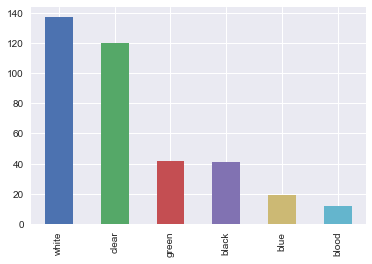

In [8]:
# 정규 분포 규칙은 숫자 데이터에만 적용되므로 범주형 데이터의 경우 막대 그래프를 살펴봐야 함

# 훈련 데이터 color 막대 그래프
train_df.color.value_counts().plot(kind='bar')

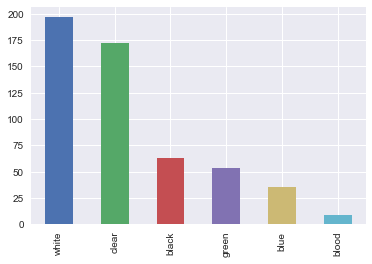

In [9]:
# 테스트 데이터 color 막대 그래프
test_df.color.value_counts().plot(kind='bar')

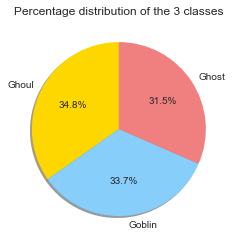

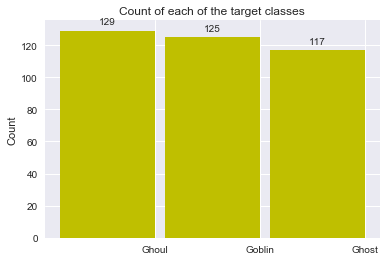

In [10]:
# 대상 변수 탐색 : 훈련 데이터 집합에서 대상 변수 '유형'의 분포
# 훈련 데이터 파이차트
type_series = train_df.type.value_counts()
labels = (np.array(type_series.index))
sizes = (np.array((type_series / type_series.sum())*100))
colors = ['gold', 'lightskyblue', 'lightcoral']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Percentage distribution of the 3 classes")
plt.show()

# create a function for labeling #
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                '%d' % int(height),
                ha='center', va='bottom')

# 막대 차트를 이용해 각 등급의 개수 파악
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots()
rects = ax.bar(ind, np.array(type_series), width=width, color='y')
ax.set_xticks(ind+((width)/2.))
ax.set_xticklabels(labels)
ax.set_ylabel("Count")
ax.set_title("Count of each of the target classes")
autolabel(rects)
plt.show()

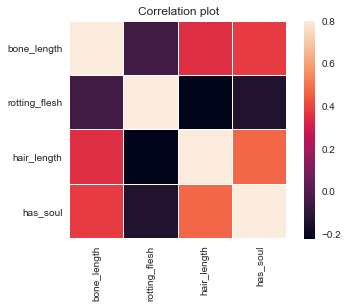

In [11]:
# 수치 변수 탐색 : 데이터 집합에 있는 숫자 변수 간의 상관관계
numerical_cols = ['bone_length', 'rotting_flesh', 'hair_length', 'has_soul']
corrmat = train_df[numerical_cols].corr()
sns.heatmap(corrmat, vmax=.8, square=True, linewidths=0.05)
plt.yticks(rotation='horizontal')
plt.title("Correlation plot")
plt.show()

<Figure size 864x864 with 0 Axes>

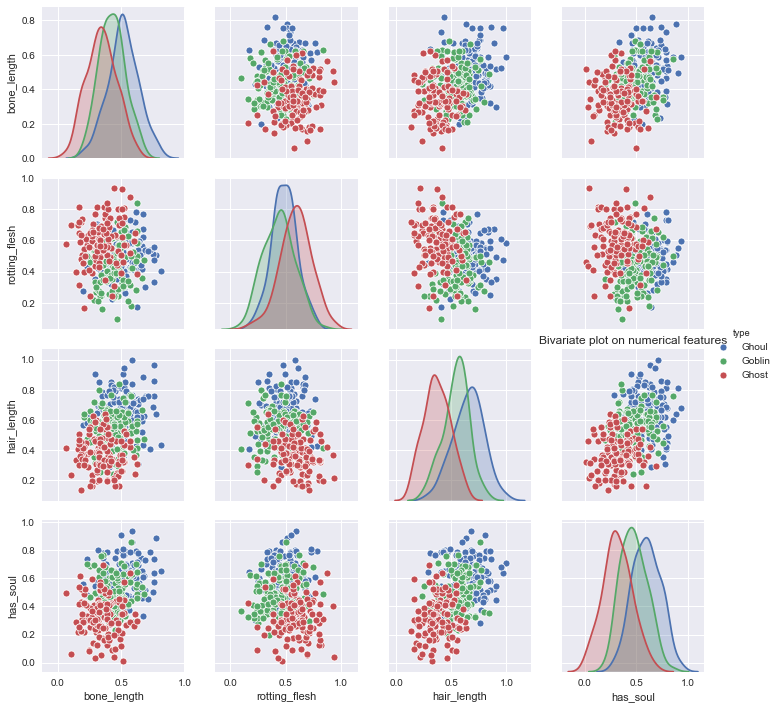

In [12]:
# 수치 변수의 양분 분포
plt.figure(figsize=(12,12))
sns.pairplot(train_df[numerical_cols+['type']], hue="type")
plt.title("Bivariate plot on numerical features")
plt.show()

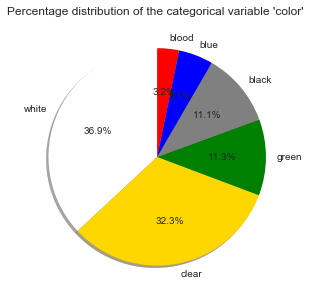

In [13]:
# 파이 차트를 만들고 비율 분포를 보십시오.
type_series = train_df.color.value_counts()
labels = (np.array(type_series.index))
sizes = (np.array((type_series / type_series.sum())*100))
colors = ['white', 'gold', 'green', 'grey', 'blue', 'red']
plt.figure(figsize=(6,5))
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Percentage distribution of the categorical variable 'color' ")
plt.show()

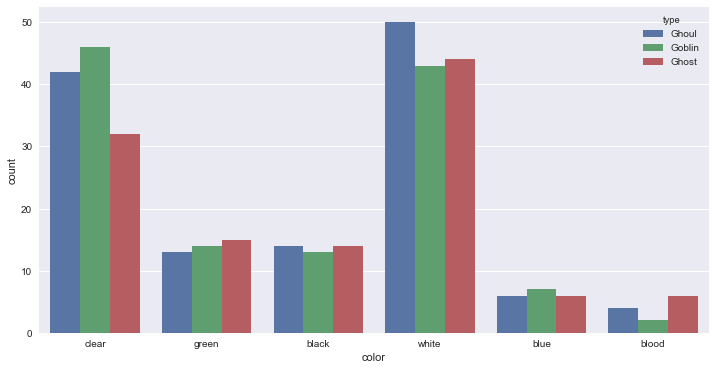

In [14]:
# 각 범주에 클래스가 어떻게 분산되는지 확인할 수 있다.
plt.figure(figsize=(12,6))
sns.countplot(x='color', hue='type', data=train_df)
plt.show()

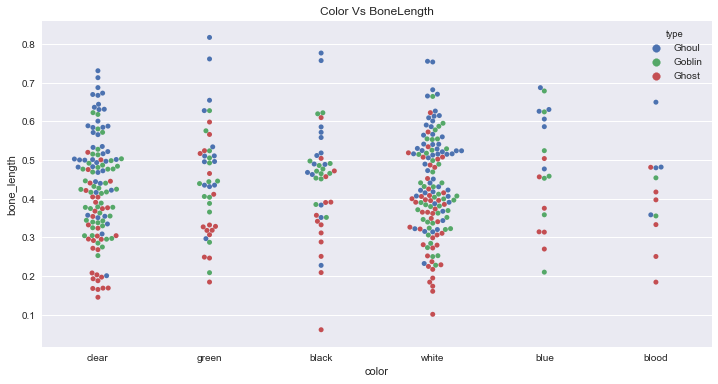

In [15]:
# 생물량 그림 : 이제 범주형 변수에 대한 변수 그림을 봅시다.

# bone_length 에 대한 변수 그림
plt.figure(figsize=(12,6))
sns.swarmplot(x="color", y="bone_length", hue="type", data=train_df)
plt.title("Color Vs BoneLength")
plt.show()

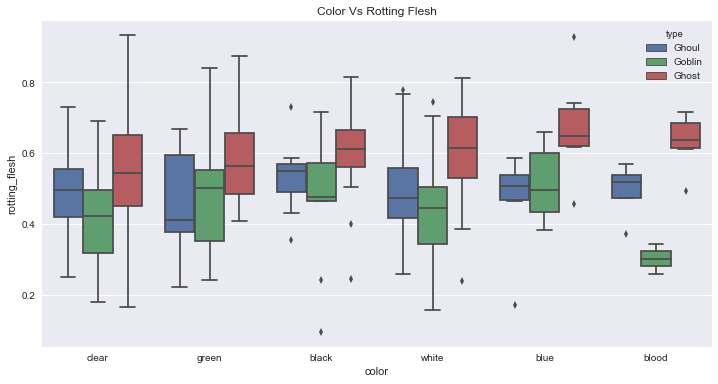

In [16]:
# rotting_flesh 에 대한 변수 그림
plt.figure(figsize=(12,6))
sns.boxplot(x="color", y="rotting_flesh", hue="type", data=train_df)
plt.title("Color Vs Rotting Flesh")
plt.show()

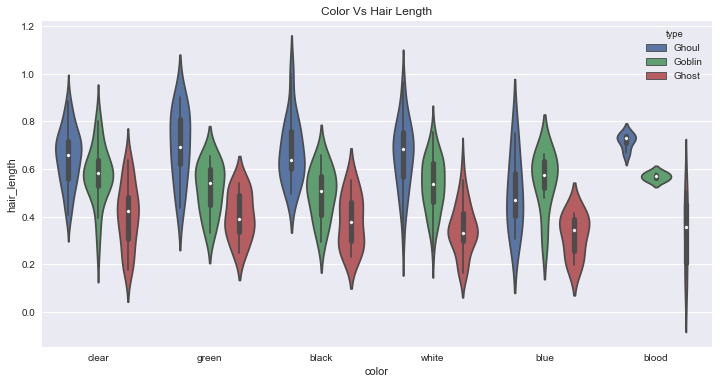

In [17]:
# hair_length 에 대한 변수 그림
plt.figure(figsize=(12,6))
sns.violinplot(x="color", y="hair_length", hue="type", data=train_df)
plt.title("Color Vs Hair Length")
plt.show()

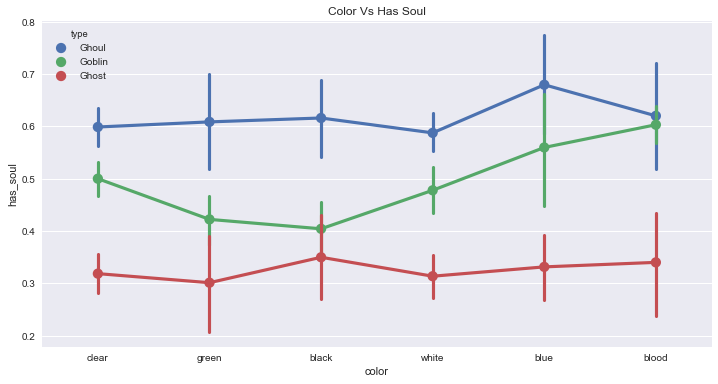

In [18]:
# has_soul 에 대한 변수 그림  
plt.figure(figsize=(12,6))
sns.pointplot(x="color", y="has_soul", hue="type", data=train_df)
plt.title("Color Vs Has Soul")
plt.show()

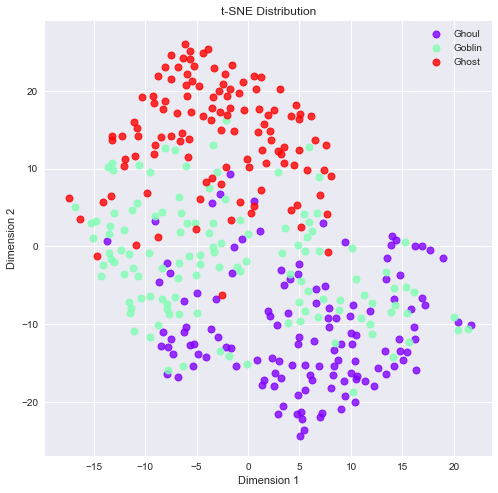

In [19]:
# t-SNE 시각화 : 숫자 변수를 가져와서 T-SNE 시각화를 수행하여 목표물이 어떻게 분리되는지 봅시다.

tsne = manifold.TSNE(n_components=2, random_state=0) 
X = np.array(train_df[numerical_cols])
X = tsne.fit_transform(X)
y = train_df.type.values

colors = cm.rainbow(np.linspace(0, 1, 3))
labels = ['Ghoul', 'Goblin', 'Ghost']
plt.figure(figsize=(8, 8))
for l, c, co, in zip(labels, colors, range(3)):
    plt.scatter(X[np.where(y == l), 0],
                X[np.where(y == l), 1],
                marker='o',
                color=c,
                linewidth='1',
                alpha=0.8,
                label=l)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("t-SNE Distribution")
plt.legend(loc='best')
plt.show()

In [20]:
train_data = train_df.drop(columns=['id'],axis=1)

In [21]:
test_data = test_df.drop(columns=['id'])

**We assign a 1 to Ghoul, 2 to Goblin and 3 to Ghost, since we need numbers for calculation in the algorithm. We cannot use string in the Machine Learning Algorithm so we need to encode them with numbers**

In [22]:
# 기계학습 알고리즘에서는 문자열을 사용할 수 없으므로 숫자로 인코딩
# 1 : Ghoul
# 2 : Goblin
# 0 : Ghost

le = LabelEncoder()
train_data['type'] = le.fit_transform(train_data['type'])
print(train_data.type.value_counts())

1    129
2    125
0    117
Name: type, dtype: int64


In [23]:
train_data_x = train_data.drop(columns=['type'],axis=1)
train_data_y = train_data['type'].values

We also have to covert the categorical variable into dummy variable. While creating dummy we need to remove one column to escape the dummy variable trap.

In [24]:
train_data_x = pd.get_dummies(train_data_x,columns=['color'],drop_first=True).values

In [25]:
y_data = pd.get_dummies(test_data, columns=['color'], drop_first=True).values

In [26]:
rfclf = model2 = RandomForestClassifier(max_depth=4, n_estimators=100, random_state=0)
rfclf.fit(train_data_x, train_data_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [27]:
y_pred = rfclf.predict(y_data)
submission['type'] = y_pred

In [28]:
# 숫자로 된 결과들의 타입을 문자열로 변경

submission['type'] = submission.type.map({0:"Ghost", 1:"Ghoul", 2:"Goblin"})
submission.to_csv('../working/submission.csv', index=False)